# Image classification with convolutional NN

The idea now is to repeat the MNIST classification problem, but using something more suitable for the image classification task at hand - a convolutional NN.

## Loading data

We saw the structure of the csv file in the previous notebook. Let's create a function to load both files and create a batched tensorflow dataset

In [1]:
import os
import pathlib

import tensorflow as tf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# Current directory, contents, and contents of the sample directory

print(f'Current directory {os.getcwd()}')
print(f'Current directory contents {os.listdir()}')

dir_of_samples = pathlib.Path('.') / 'sample_data'
assert dir_of_samples.is_dir(), 'Not a valid directory'

print(f'Samples directory contents {os.listdir(dir_of_samples)}')

Current directory /content
Current directory contents ['.config', 'sample_data']
Samples directory contents ['anscombe.json', 'README.md', 'mnist_test.csv', 'california_housing_test.csv', 'california_housing_train.csv', 'mnist_train_small.csv']


In [3]:
train_file = dir_of_samples / 'mnist_train_small.csv'
test_file = dir_of_samples / 'mnist_test.csv'

assert train_file.is_file(), 'Not a valid address for the training file'
assert test_file.is_file(), 'Not a valid address for the testing file'

In [4]:
import csv

In [5]:
with open(train_file, 'r') as f:
  reader = csv.reader(f)
  # Let's print thje first line
  line_0 = next(reader)
print(f'Number of elements in the first line : {len(line_0)}')
print(line_0)

Number of elements in the first line : 785
['6', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '24', '67', '67', '18', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '131', '252', '252', '66', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '159', '250', '232', '30', '32', '0', '0', '0', '0', '0

Ok, as we saw in the previous notebook, the first element is the label, and the 784 following ones are the digit 28x28 handwriten image flattened to a single raw vector.

Now, the dataset has to be a dataset of 28x28 images! not flattened ones, for the convolutional NN.

In [6]:
SHUFFLE_BUFFER = 1000
BATCH_NUMBER = 100

def get_dataset(file_path, flat_images = False):
  #1st: get the file header
  with open(file_path, 'r') as f:
    reader = csv.reader(f)
    line_length = len(next(reader))
    assert line_length == 785, 'The provided file is wrongly formated - no 28x28 flattened images'

  raw_data = pd.read_csv(file_path, names = range(line_length)).to_numpy().astype(np.float32)
  #Creating the dataset tensor instance (generator)
  dataset = tf.data.Dataset.from_tensor_slices(raw_data)
  #Assessing if we want flatten images (deep-Dense-NN) or shaped ones (CNN)
  if not flat_images:
    dataset = dataset.map(lambda data : (tf.reshape(data[1:],(28,28)),data[0]))
  else:
    dataset = dataset.map(lambda data : (data[1:],data[0]))
  # Shuffle
  dataset = dataset.shuffle(SHUFFLE_BUFFER)
  # Batch
  dataset = dataset.batch(BATCH_NUMBER).prefetch(1)

  return dataset


In [7]:
train_dataset = get_dataset(train_file)
test_dataest = get_dataset(test_file)

## Convolutional model - CNN

Let's test a simple convolutional neural network, to see some of the features we may expect in a larger and more complex model.

In [13]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Lambda(
            lambda data : tf.expand_dims(data, axis  = -1),
            input_shape = (28,28)
        ), # We need this to match dimensions
        tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(16, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
    ]
)

model.summary()

model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
    #optimizer= tf.keras.optimizers.Adam(learning_rate = 0.0001),
    optimizer= tf.keras.optimizers.RMSprop(learning_rate = 0.0001),
    metrics = ['accuracy']
)



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 28, 28, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 5408)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               692352    
                                                                 
 dense_7 (Dense)             (None, 16)                2064      
                                                      

In [14]:
model_h = model.fit(train_dataset, epochs = 10)

Epoch 1/10
200/200 [==============================] - 14s 65ms/step - loss: 1.9406 - accuracy: 0.4951
Epoch 2/10
200/200 [==============================] - 11s 57ms/step - loss: 0.8664 - accuracy: 0.7742
Epoch 3/10
200/200 [==============================] - 11s 57ms/step - loss: 0.6913 - accuracy: 0.8223
Epoch 4/10
200/200 [==============================] - 13s 63ms/step - loss: 0.5627 - accuracy: 0.8802
Epoch 5/10
200/200 [==============================] - 12s 57ms/step - loss: 0.4614 - accuracy: 0.9330
Epoch 6/10
200/200 [==============================] - 11s 57ms/step - loss: 0.3994 - accuracy: 0.9432
Epoch 7/10
200/200 [==============================] - 11s 57ms/step - loss: 0.3569 - accuracy: 0.9551
Epoch 8/10
200/200 [==============================] - 11s 57ms/step - loss: 0.3275 - accuracy: 0.9631
Epoch 9/10
200/200 [==============================] - 11s 53ms/step - loss: 0.2938 - accuracy: 0.9645
Epoch 10/10
200/200 [==============================] - 11s 57ms/step - loss: 0.149

It's a bit slower than the densely layered NN, but it's working fine

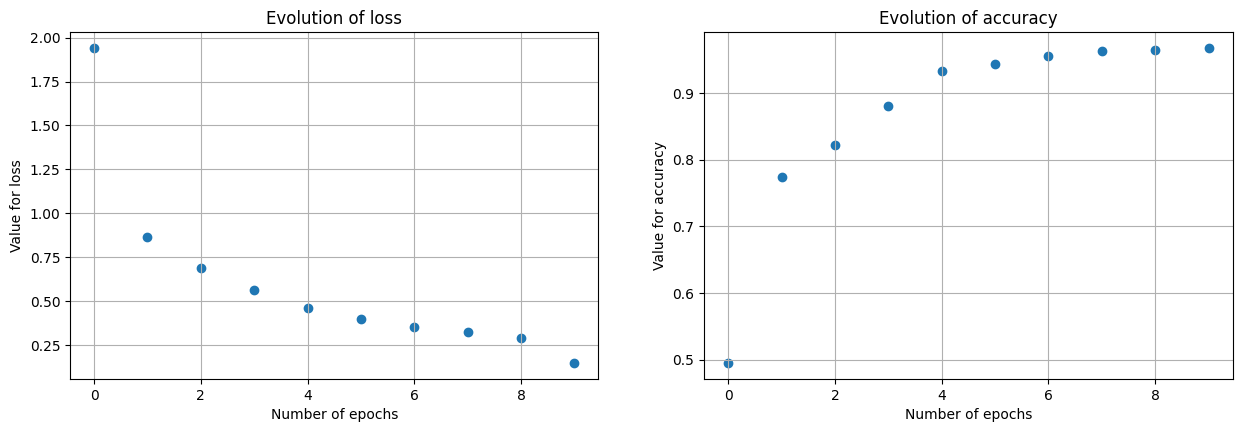

In [15]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,4.5), squeeze=False)

list_scores = ['loss', 'accuracy']

for i,ax in enumerate(axes.flatten()):
  ax.scatter(model_h.epoch, model_h.history[list_scores[i]])
  ax.grid(True)
  ax.set_title(f"Evolution of {list_scores[i]}")
  ax.set_xlabel("Number of epochs")
  ax.set_ylabel(f"Value for {list_scores[i]}")

fig.show()

Ok, let's try something else now.

1. Let's try a deeper architecture. At least 2 convolutional blocks, with an increasing number of channels as we progress deeper into the net. So we can get different features identified by the net.

2. Let's implement a callback, so we can carry out an epoch-by-epoch test for the accuracy measurement. Then, at a given threshold we can stop the training and inspect the results.

3. After that threshold is reached, we can always continue the training process and see if we can get even better results.

4. We will also conduct an experiment on the learning_rate for the Adam optimizer

In [27]:
model = tf.keras.Sequential(
    [
        
        tf.keras.layers.Lambda(
            lambda data : tf.expand_dims(data, axis = -1),
            input_shape = (28,28)
        ),
        tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax'),
    ]
)

model.summary()

model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    metrics = ['accuracy']
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 28, 28, 1)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1600)             

In [28]:
import typing
from dataclasses import field

In [29]:
class Epoch_Callback(tf.keras.callbacks.Callback):
  # Class inhereting from the keras Callback Base class
  
  def __init__(self, training_acc : float = 0.98, validation_acc : float = 0.95):
    super().__init__()
    self.train_threshold = training_acc
    self.val_threshold = validation_acc

  def halting_message(self, train = ' - ', val = ' - '):
    str0 = '\nReached thresholds\n'
    str1 = f'Training Accuracy {train} >= {self.train_threshold}'
    str2 = f'validation Accuracy {val} >= {self.val_threshold}'
    print('\n'.join([str0,str1,str2]))
    self.model.stop_training = True


  def on_epoch_end(self, epoch, logs = field(init=typing.Dict)):
    # This is required by the protocol
    current_train_acc = logs.get('accuracy')
    current_val_acc = logs.get('val_accuracy')

    if current_val_acc:
      # Case of having validation activated
      if (
          current_train_acc >= self.train_threshold and
          current_val_acc >= self.val_threshold):
        self.halting_message(
            str(round(current_train_acc, 4)), 
            str(round(current_val_acc, 4))
        )
    else:
      if current_train_acc >= self.train_threshold:
        self.halting_message(
            str(round(current_train_acc, 4))
        )

Let's try it with only a few epochs and a small requirement, using only training dataset

In [30]:
haltingCallback = Epoch_Callback(training_acc=0.8, validation_acc = 0.7)

In [31]:
model_h = model.fit(
    train_dataset,
    epochs = 10,
    callbacks= [haltingCallback]
)

Epoch 1/10
200/200 [==============================] - 26s 122ms/step - loss: 4.3033 - accuracy: 0.6067
Epoch 2/10
200/200 [==============================] - ETA: 0s - loss: 0.3097 - accuracy: 0.9068
Reached thresholds

Training Accuracy 0.9068 >= 0.8
validation Accuracy  -  >= 0.7
200/200 [==============================] - 24s 118ms/step - loss: 0.3097 - accuracy: 0.9068


In [32]:
model_h.history

{'loss': [4.30327033996582, 0.3097148537635803],
 'accuracy': [0.6067000031471252, 0.9067500233650208]}

In [33]:
# Further improving the fit - from the previous callback
haltingCallback = Epoch_Callback(training_acc=0.95, validation_acc = 0.92)

model_h2 = model.fit(
    train_dataset,
    epochs = 10,
    initial_epoch = model_h.epoch[-1] + 1,
    validation_data= test_dataest,
    callbacks= [haltingCallback]
)

Epoch 3/10
200/200 [==============================] - 47s 236ms/step - loss: 0.2271 - accuracy: 0.9315 - val_loss: 0.2098 - val_accuracy: 0.9404
Epoch 4/10
200/200 [==============================] - 24s 122ms/step - loss: 0.1859 - accuracy: 0.9441 - val_loss: 0.1965 - val_accuracy: 0.9406
Epoch 5/10
200/200 [==============================] - 24s 119ms/step - loss: 0.1839 - accuracy: 0.9467 - val_loss: 0.1717 - val_accuracy: 0.9482
Epoch 6/10
200/200 [==============================] - 25s 126ms/step - loss: 0.1750 - accuracy: 0.9474 - val_loss: 0.1893 - val_accuracy: 0.9447
Epoch 7/10
200/200 [==============================] - ETA: 0s - loss: 0.1512 - accuracy: 0.9549
Reached thresholds

Training Accuracy 0.9549 >= 0.95
validation Accuracy 0.9559 >= 0.92
200/200 [==============================] - 25s 123ms/step - loss: 0.1512 - accuracy: 0.9549 - val_loss: 0.1463 - val_accuracy: 0.9559


In [34]:
model_h2.history

{'loss': [0.22708283364772797,
  0.1858697086572647,
  0.18394704163074493,
  0.1750015914440155,
  0.15118692815303802],
 'accuracy': [0.9314500093460083,
  0.9441499710083008,
  0.9466999769210815,
  0.9473999738693237,
  0.9549499750137329],
 'val_loss': [0.2097853273153305,
  0.19645783305168152,
  0.1717490702867508,
  0.18927256762981415,
  0.1463228017091751],
 'val_accuracy': [0.9404000043869019,
  0.9405999779701233,
  0.948199987411499,
  0.9447000026702881,
  0.9559000134468079]}

In [38]:
# Putting the info together
model_history = dict()

for key,item in model_h.history.items():
  model_history[key] = item

for key,item in model_h2.history.items():
  if key in model_history:
    model_history[key].extend(item)
  else:
    model_history[key] = item

epochs = range(1, model_h2.epoch[-1]+2)

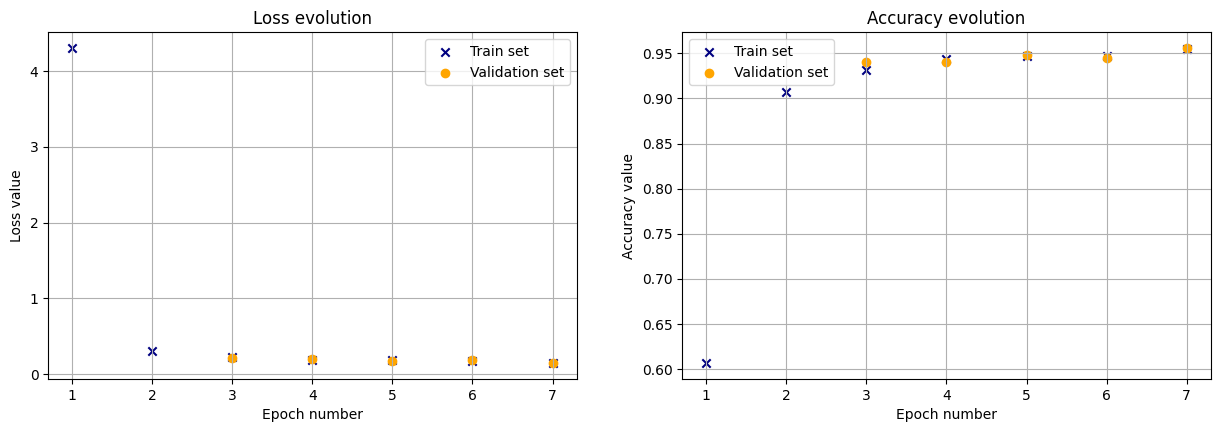

In [45]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,4.5))
axes[0].scatter(epochs, model_history['loss'], c = 'navy', label = 'Train set', marker = 'x')
axes[0].scatter([el + 1 for el in model_h2.epoch], model_history['val_loss'], c = 'orange', label = 'Validation set')
axes[0].set_title('Loss evolution')
axes[0].set_xlabel('Epoch number')
axes[0].set_ylabel('Loss value')
axes[0].grid(True)
axes[0].legend()

axes[1].scatter(epochs, model_history['accuracy'], c = 'navy', label = 'Train set', marker = 'x')
axes[1].scatter([el + 1 for el in model_h2.epoch], model_history['val_accuracy'], c = 'orange', label = 'Validation set')
axes[1].set_title('Accuracy evolution')
axes[1].set_xlabel('Epoch number')
axes[1].set_ylabel('Accuracy value')
axes[1].grid(True)
axes[1].legend()

**It works !** 

Let's find out the correct learning rate for Adam ...

In [63]:
INITIAL_lr = 1e-03
lr_scheduller = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch : INITIAL_lr * 10 ** (epoch / 10)
)

We are now interested in checking when we get very bad accuracies. As soon as we go below a given threshold, we abort fitting

In [64]:
class Epoch_Callback_2(tf.keras.callbacks.Callback):
  # Class inhereting from the keras Callback Base class
  
  def __init__(self, training_acc : float = 0.5, validation_acc : float = 0.4):
    super().__init__()
    self.train_threshold = training_acc
    self.val_threshold = validation_acc

  def halting_message(self, train = ' - ', val = ' - ', epoch = 0):
    str0 = '\nReached thresholds\n'
    str1 = f'Training Accuracy {train} <= {self.train_threshold}'
    str2 = f'validation Accuracy {val} <= {self.val_threshold}'
    str3 = f'At epoch = {epoch}'
    print('\n'.join([str0,str1,str2]))
    self.model.stop_training = True


  def on_epoch_end(self, epoch, logs = field(init=typing.Dict)):
    # This is required by the protocol
    current_train_acc = logs.get('accuracy')
    current_val_acc = logs.get('val_accuracy')

    if current_val_acc:
      # Case of having validation activated
      if (
          current_train_acc <= self.train_threshold and
          current_val_acc <= self.val_threshold and 
          epoch > 10):
        self.halting_message(
            str(round(current_train_acc, 4)), 
            str(round(current_val_acc, 4)),
            epoch = epoch
        )
    else:
      if (
          current_train_acc <= self.train_threshold and 
          epoch > 10):
        self.halting_message(
            str(round(current_train_acc, 4)),
            epoch = epoch
        )

In [65]:
MAX_EPOCH = 50
haltingCallback2 = Epoch_Callback_2(training_acc = 0.5, validation_acc = 0.5)

# Recompile the model, to restart

model = tf.keras.Sequential(
    [
        
        tf.keras.layers.Lambda(
            lambda data : tf.expand_dims(data, axis = -1),
            input_shape = (28,28)
        ),
        tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax'),
    ]
)

model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = INITIAL_lr),
    metrics = ['accuracy']
)

model_h = model.fit(
    train_dataset,
    epochs = MAX_EPOCH,
    validation_data= test_dataest,
    callbacks= [haltingCallback2, lr_scheduller]
)

Epoch 1/50
200/200 [==============================] - 27s 128ms/step - loss: 0.7357 - accuracy: 0.8863 - val_loss: 0.1306 - val_accuracy: 0.9616 - lr: 0.0010
Epoch 2/50
200/200 [==============================] - 26s 128ms/step - loss: 0.1055 - accuracy: 0.9676 - val_loss: 0.1042 - val_accuracy: 0.9718 - lr: 0.0013
Epoch 3/50
200/200 [==============================] - 26s 128ms/step - loss: 0.0656 - accuracy: 0.9785 - val_loss: 0.0914 - val_accuracy: 0.9751 - lr: 0.0016
Epoch 4/50
200/200 [==============================] - 25s 126ms/step - loss: 0.0552 - accuracy: 0.9809 - val_loss: 0.0928 - val_accuracy: 0.9747 - lr: 0.0020
Epoch 5/50
200/200 [==============================] - 27s 134ms/step - loss: 0.0525 - accuracy: 0.9822 - val_loss: 0.0920 - val_accuracy: 0.9736 - lr: 0.0025
Epoch 6/50
200/200 [==============================] - 25s 124ms/step - loss: 0.0617 - accuracy: 0.9810 - val_loss: 0.0838 - val_accuracy: 0.9761 - lr: 0.0032
Epoch 7/50
200/200 [==============================] 

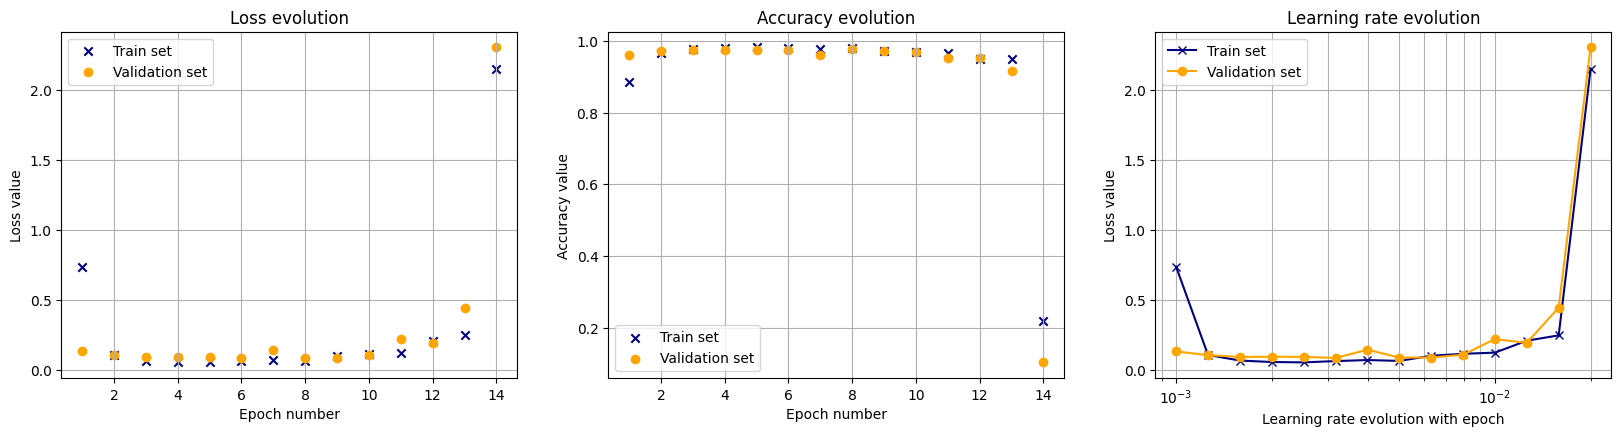

In [69]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20,4.5))
axes[0].scatter([el +1 for el in model_h.epoch], model_h.history['loss'], c = 'navy', label = 'Train set', marker = 'x')
axes[0].scatter([el +1 for el in model_h.epoch], model_h.history['val_loss'], c = 'orange', label = 'Validation set')
axes[0].set_title('Loss evolution')
axes[0].set_xlabel('Epoch number')
axes[0].set_ylabel('Loss value')
axes[0].grid(True)
axes[0].legend()

axes[1].scatter([el +1 for el in model_h.epoch], model_h.history['accuracy'], c = 'navy', label = 'Train set', marker = 'x')
axes[1].scatter([el +1 for el in model_h.epoch], model_h.history['val_accuracy'], c = 'orange', label = 'Validation set')
axes[1].set_title('Accuracy evolution')
axes[1].set_xlabel('Epoch number')
axes[1].set_ylabel('Accuracy value')
axes[1].grid(True)
axes[1].legend() 

axes[2].plot(model_h.history['lr'], model_h.history['loss'], c = 'navy', label = 'Train set', marker = 'x')
axes[2].plot(model_h.history['lr'], model_h.history['val_loss'], c = 'orange', label = 'Validation set', marker = 'o')
axes[2].set_title('Learning rate evolution')
axes[2].set_xscale('log')
axes[2].set_xlabel('Learning rate evolution with epoch')
axes[2].set_ylabel('Loss value')
axes[2].grid(True, which = 'both')
axes[2].legend() 

So, we can finally begin a larger fitting process, with a better learning rate (decreasing as we keep advancing in the training process) and a end point threshold defined

In [77]:
INITIAL_lr = 5e-03
lr_scheduller = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch : INITIAL_lr / (10 ** (epoch / 25))
)

# Each 10 epochs, we decrease the learning rate

MAX_EPOCH = 100
haltingCallback = Epoch_Callback(training_acc = 0.985, validation_acc = 0.97)

# Recompile the model, to restart

model = tf.keras.Sequential(
    [
        
        tf.keras.layers.Lambda(
            lambda data : tf.expand_dims(data, axis = -1),
            input_shape = (28,28)
        ),
        tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax'),
    ]
)

model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = INITIAL_lr),
    metrics = ['accuracy']
)

model_h = model.fit(
    train_dataset,
    epochs = MAX_EPOCH,
    validation_data= test_dataest,
    callbacks= [haltingCallback, lr_scheduller]
)

Epoch 1/100
200/200 [==============================] - 27s 125ms/step - loss: 2.1337 - accuracy: 0.8503 - val_loss: 0.1622 - val_accuracy: 0.9513 - lr: 0.0050
Epoch 2/100
200/200 [==============================] - 22s 111ms/step - loss: 0.1284 - accuracy: 0.9612 - val_loss: 0.1189 - val_accuracy: 0.9635 - lr: 0.0046
Epoch 3/100
200/200 [==============================] - 26s 131ms/step - loss: 0.1004 - accuracy: 0.9681 - val_loss: 0.1115 - val_accuracy: 0.9684 - lr: 0.0042
Epoch 4/100
200/200 [==============================] - 25s 126ms/step - loss: 0.0616 - accuracy: 0.9807 - val_loss: 0.1290 - val_accuracy: 0.9692 - lr: 0.0038
Epoch 5/100
200/200 [==============================] - 24s 120ms/step - loss: 0.0532 - accuracy: 0.9822 - val_loss: 0.1316 - val_accuracy: 0.9664 - lr: 0.0035
Epoch 6/100
200/200 [==============================] - 24s 119ms/step - loss: 0.0417 - accuracy: 0.9862 - val_loss: 0.1371 - val_accuracy: 0.9678 - lr: 0.0032
Epoch 7/100
200/200 [=========================

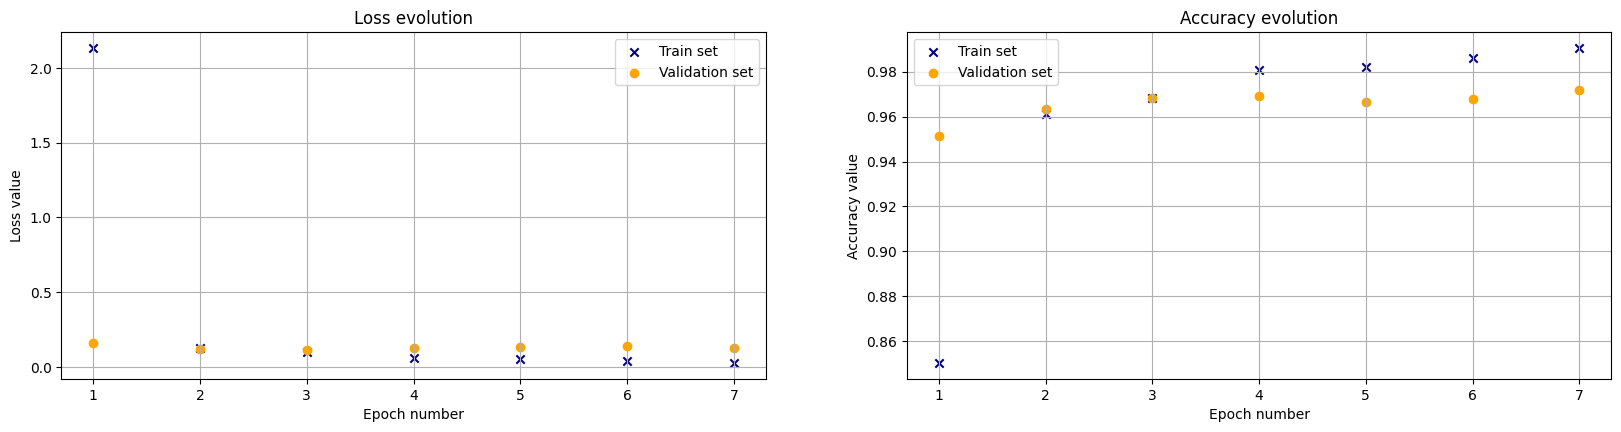

In [78]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20,4.5))
axes[0].scatter([el +1 for el in model_h.epoch], model_h.history['loss'], c = 'navy', label = 'Train set', marker = 'x')
axes[0].scatter([el +1 for el in model_h.epoch], model_h.history['val_loss'], c = 'orange', label = 'Validation set')
axes[0].set_title('Loss evolution')
axes[0].set_xlabel('Epoch number')
axes[0].set_ylabel('Loss value')
axes[0].grid(True)
axes[0].legend()

axes[1].scatter([el +1 for el in model_h.epoch], model_h.history['accuracy'], c = 'navy', label = 'Train set', marker = 'x')
axes[1].scatter([el +1 for el in model_h.epoch], model_h.history['val_accuracy'], c = 'orange', label = 'Validation set')
axes[1].set_title('Accuracy evolution')
axes[1].set_xlabel('Epoch number')
axes[1].set_ylabel('Accuracy value')
axes[1].grid(True)
axes[1].legend() 

Not bad.

Let's see what the convolutional layers are doing - so let's pass some digits to the network, and extract the info after the convolutional / maxpool layer

In [115]:
def pick_random_from_dataset(dataset, show = True):
  NUMBER_OF_IMAGES = 8
  number_batches = dataset.cardinality().numpy()

  images = []
  labels = []

  for i, (batch, labels) in enumerate(dataset.take(number_batches)):
    numpy_images = batch.numpy()
    numpy_labels = labels.numpy()
    n_images_batch = numpy_images.shape[0]

    random_pick = np.random.randint(0,n_images_batch - 1)

    images.append(numpy_images[random_pick,:,:])
    images.append(numpy_labels[random_pick])
    if i >= NUMBER_OF_IMAGES:
      break

  if show:
    figure, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (20,10), squeeze = False)
    for k, ax in enumerate(axes.flatten()):
      ax.imshow(numpy_images[k], cmap = 'Greys')
      ax.set_xticks([])
      ax.set_yticks([]) 
      ax.set_title(f'True digit value {numpy_labels[k]}')
    figure.show()

  return images, labels

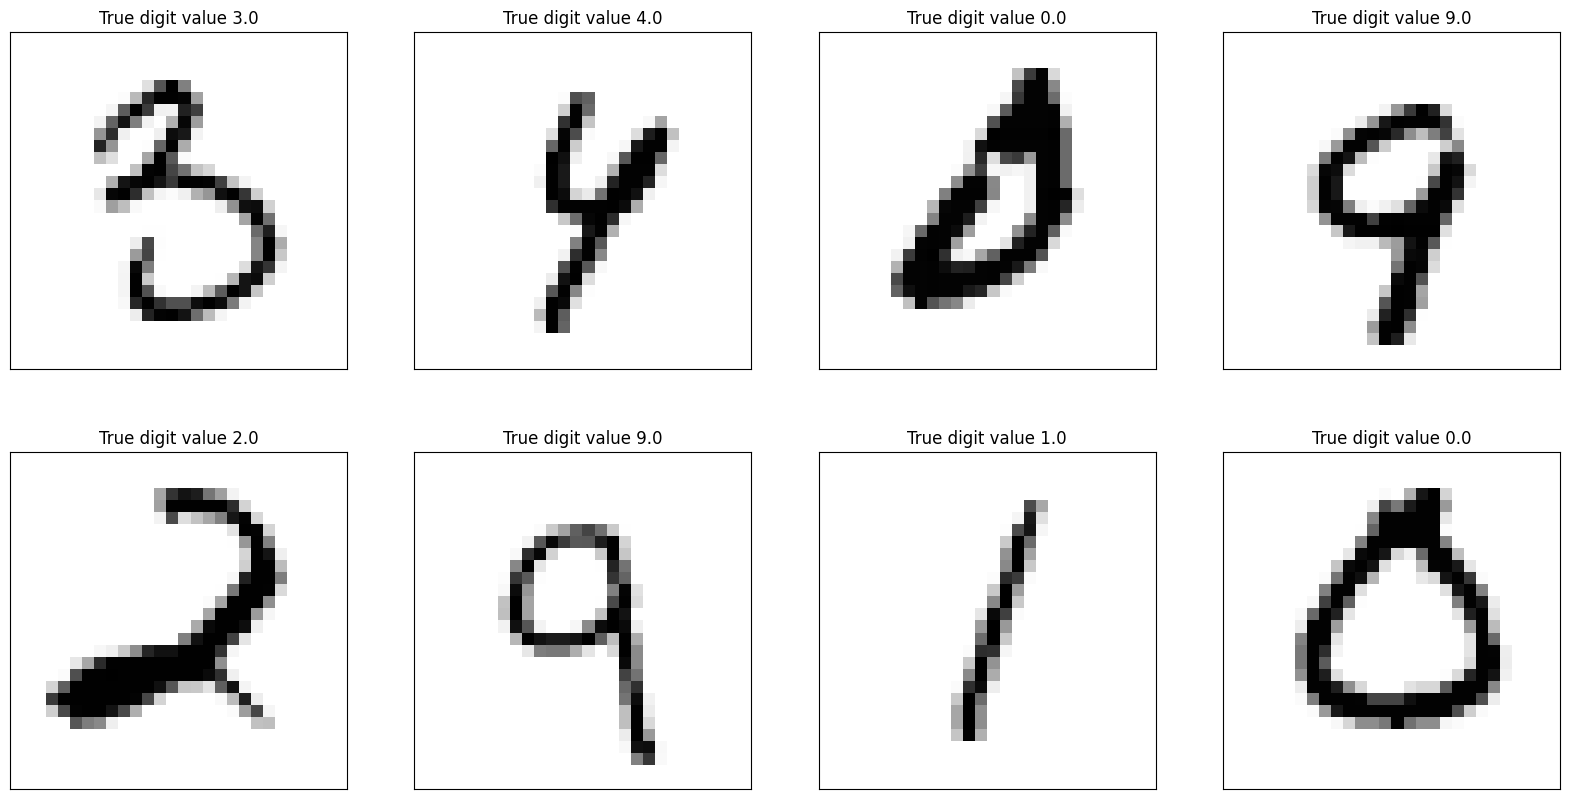

In [116]:
images,labels = pick_random_from_dataset(train_dataset)

In [118]:
# The idea is to create a visualization model, that will have as outputs the 
# orginal model layers output 

layers_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = layers_outputs)

# Let's try a simple image

index = 0
x = np.expand_dims(np.array(images[index], dtype = np.float32), axis = 0)
x /= 255.

In [120]:
# So we can get the names over the images
layer_names = [layer.name for layer in model.layers[1:]]
layer_names

['conv2d_15',
 'max_pooling2d_15',
 'conv2d_16',
 'max_pooling2d_16',
 'flatten_9',
 'dense_27',
 'dense_28',
 'dense_29']

In [121]:
features_map = visualization_model.predict(x)

1/1 [==============================] - 0s 229ms/step


In [138]:
print(len(features_map), features_map[3].shape)


8 (1, 5, 5, 64)


In [130]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_9 (Lambda)           (None, 28, 28, 1)         0         
                                                                 
 conv2d_15 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 1600)             

In [150]:
def plot_features(features_map, layers_names):
  """ Method to plot the features after each convolutional layer
  Only plotting the output features for the Conv2D and the MaxPooling2D.

  The number of channels goes as 32 - 32 - 64 - 64

  """

  figures = []
  channels = [32,32,64,64]
  rows_cols = [(4,8), (4,8), (4, 16), (4, 16)]
  cmaps = ['magma','viridis','plasma','Greys']

  for i, feature_set in enumerate(features_map):
    nr, nc = rows_cols[i]
    figure, axes = plt.subplots(nrows = nr, ncols= nc, figsize = (24,16), squeeze = False)
    figure.suptitle(f'Features of layer - {layers_names[i]}')
    for k, ax in enumerate(axes.flatten()):
      ax.set_title(f'# {k}')
      ax.imshow(feature_set[0,:,:,k], cmap = cmaps[i])
      ax.set_xticks([])
      ax.set_yticks([])
    
    plt.close()

    figures.append(figure)

  return figures

In [151]:
figures = plot_features(features_map[:4], layer_names[:4])

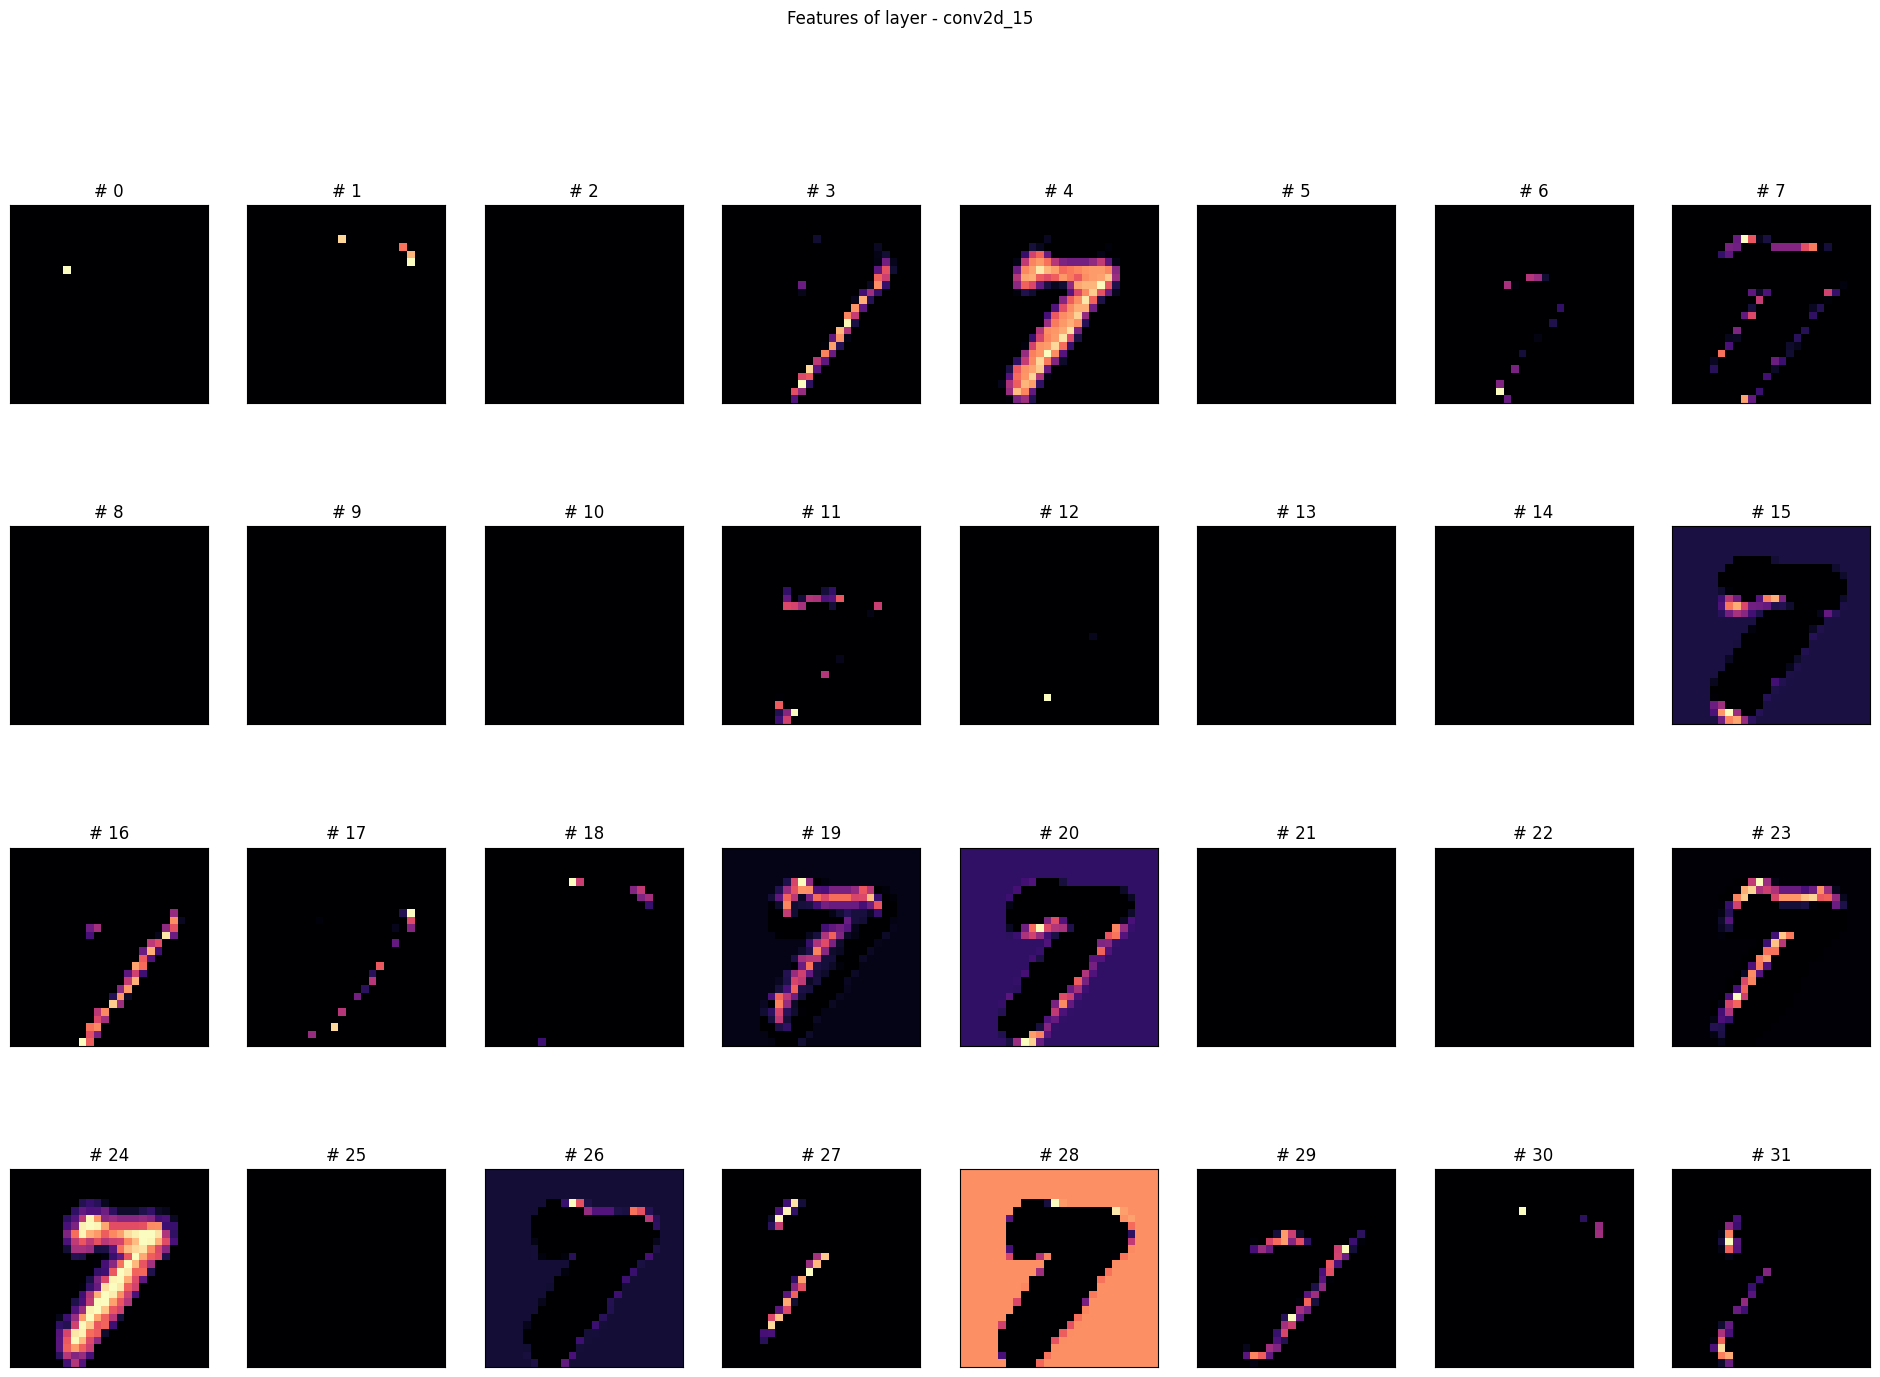

In [153]:
figures[0]

We can try different images, to see if different filters will catch up different features

1/1 [==============================] - 0s 42ms/step


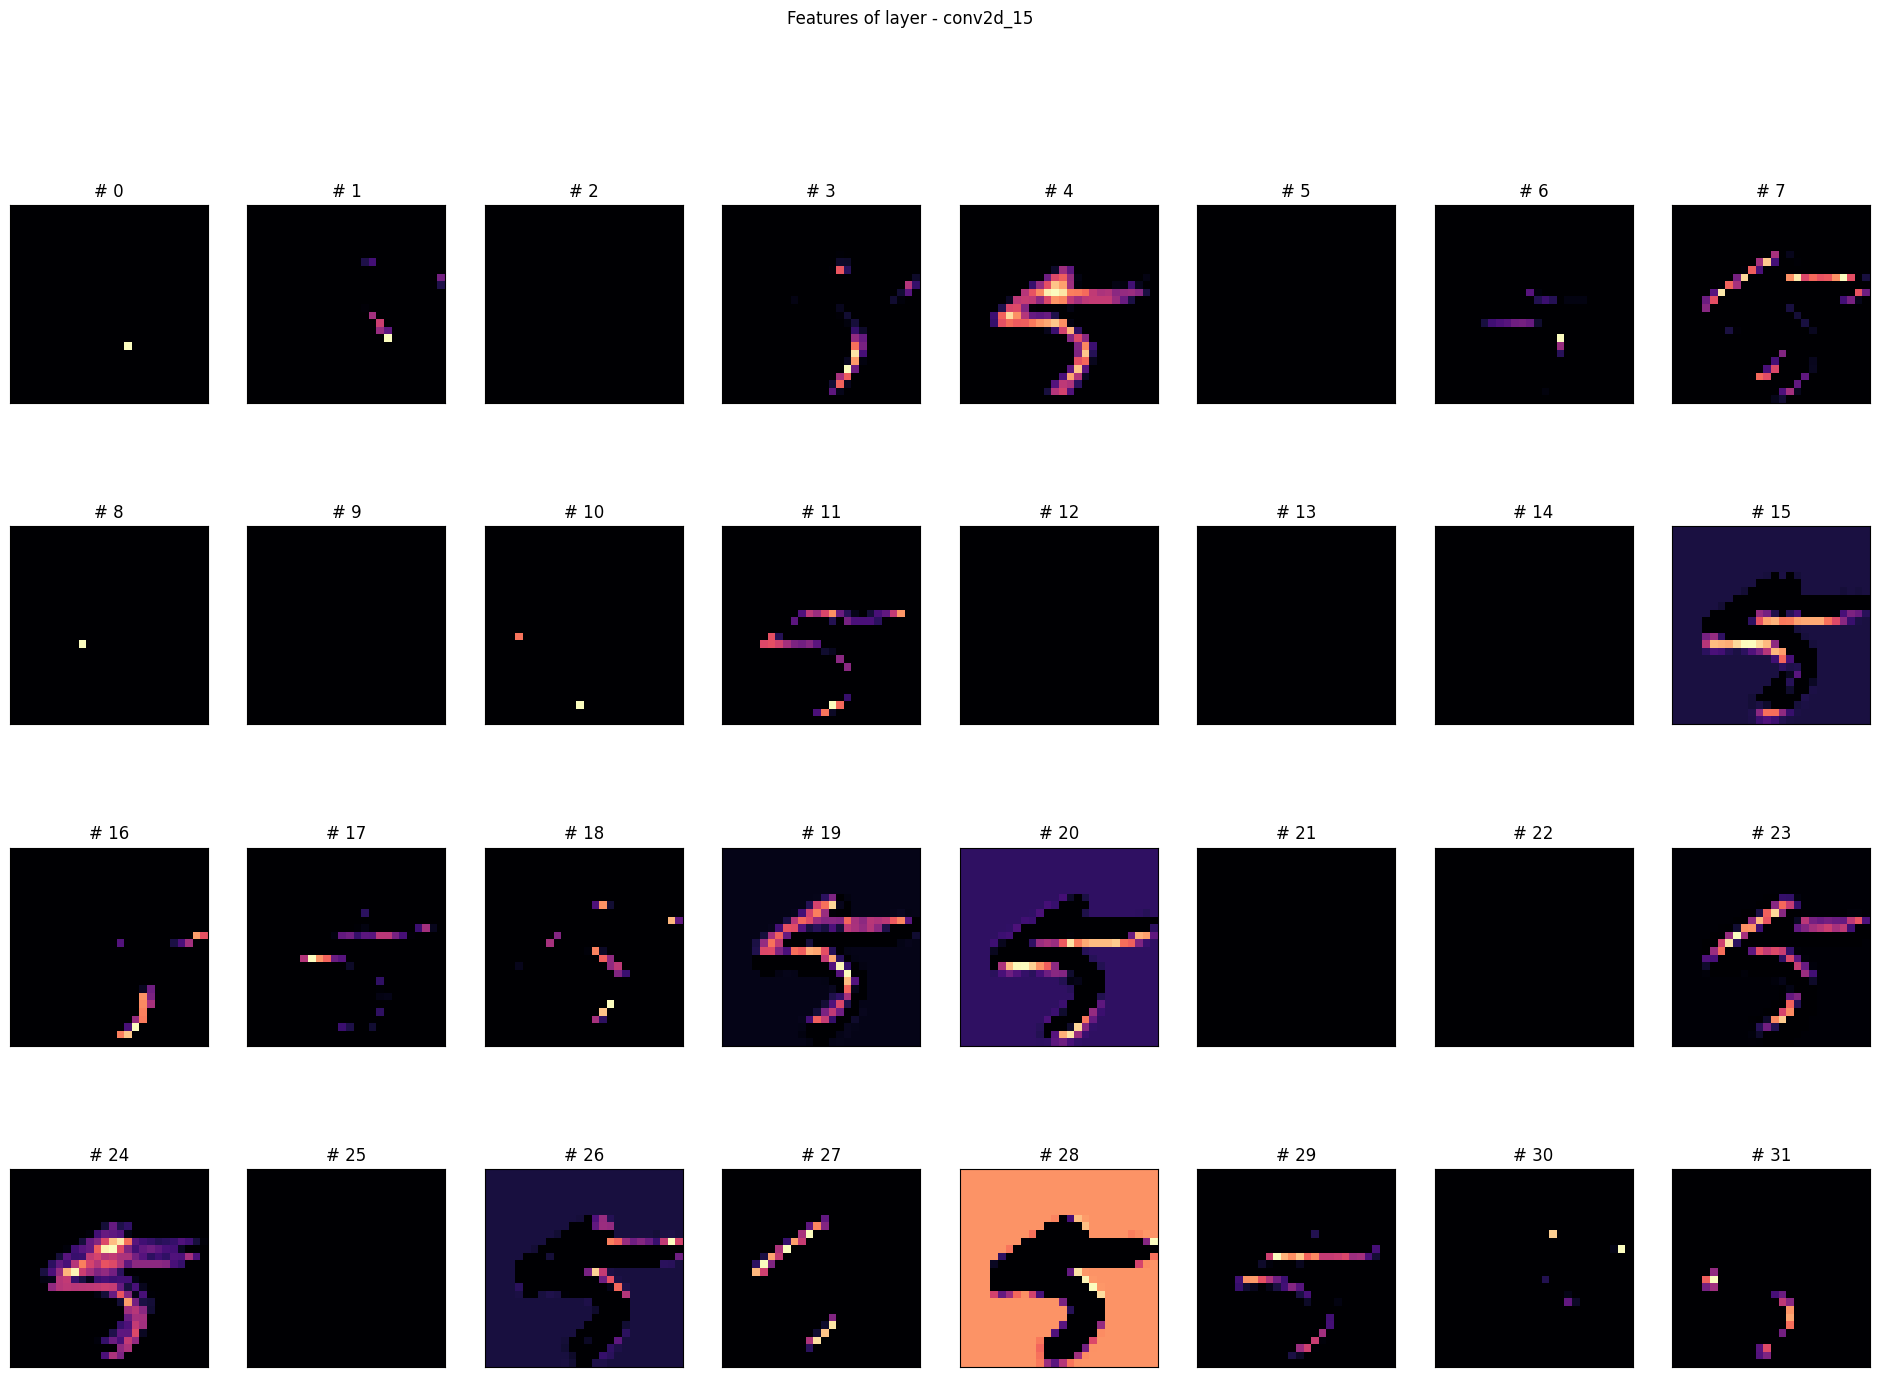

In [154]:
index = 2
x = np.expand_dims(np.array(images[index], dtype = np.float32), axis = 0)
x /= 255.
features_map = visualization_model.predict(x)
figures2 = plot_features(features_map[:4], layer_names[:4])
figures2[0]